<a href="https://colab.research.google.com/github/ijazahmad-star/Colab-Workspace/blob/main/oct%2020%202025/Agents_Workflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
!pip install langchain_google_genai langgraph

In [ ]:
from typing import Annotated, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
import operator, json, os

In [ ]:
llm = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash",
            temperature=0,
            google_api_key=api_key
        )

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '6384585b-24c4-4211-b4ea-419258f3c668',
  'type': 'tool_call'}]

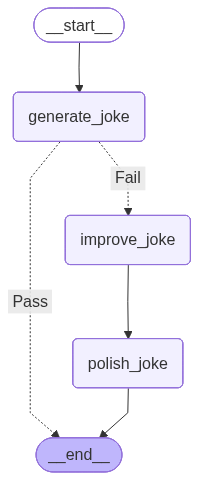

Initial joke:
Why did the cat sit on the computer?
To keep an eye on the mouse!

--- --- ---

Joke failed quality gate - no punchline detected!


In [ ]:
## prompt-chaining

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

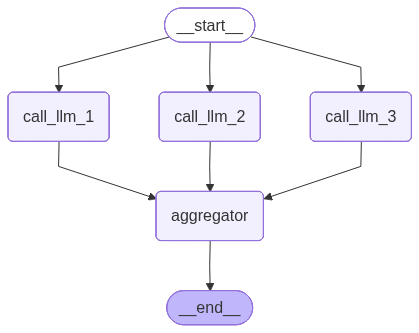

Here's a story, joke, and poem about cats!

STORY:
Jasper was a creature of habit, and his habits were, in his humble opinion, perfect. The first sliver of dawn, a pale grey against the window, was his cue. A long, luxurious stretch, each claw extended and retracted with satisfying precision. Then, a dignified leap from the plush armchair to the cool wooden floor, a quick shake of his ginger fur, and a purposeful saunter towards the kitchen.

The Tall Ones, his devoted staff, usually stirred around this time, prompted by the subtle rumble of his stomach (or, if they were particularly slow, a gentle head-butt to the face). Today, however, there was a new, unsettling element to his morning ritual: Luna.

Luna was a sleek, black shadow, all sharp angles and boundless energy, barely a year old. She had arrived six months ago, a tiny, wide-eyed bundle of chaos, and had since made it her life’s mission to disrupt Jasper’s perfectly ordered universe.

As Jasper approached the food bowl, expec

In [ ]:
## parallel
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

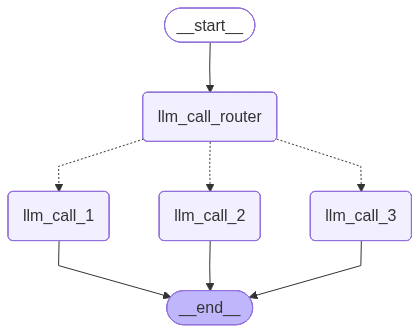

A shadow soft, a silent grace,
With velvet paws and knowing face.
A creature of both night and day,
Who walks its own mysterious way.

With liquid spine and agile leap,
Secrets of the wild they keep.
A flicking tail, a watchful eye,
As silent as a cloud passing by.

They seek the sun, a warm embrace,
And nap in any chosen place.
A curled-up ball, a gentle sigh,
As hours of slumber softly fly.

Then sudden burst of playful might,
A pouncing joy, a mock-fierce bite.
A crumpled paper, string, or toy,
Ignites their hunter's ancient joy.

A gentle rub against your leg,
A silent, soft, demanding beg.
Then on your lap, a rumbling sound,
The deepest purr, profoundly found.

They gaze with eyes of emerald green,
At things by human eyes unseen.
A touch of wildness, ever near,
Dispelling doubt, dispelling fear.

From ancient lands to hearth and home,
Wherever human spirits roam,
The cat, a friend, a furry king,
The quiet joy their presence bring.


In [ ]:
## routing
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])

In [ ]:
## Orchestrator-worker
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

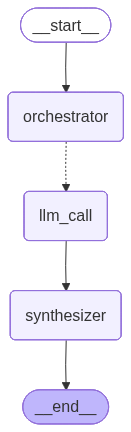

### Introduction to LLM Scaling Laws

LLM scaling laws describe the predictable relationships between a large language model's performance and the resources used to train it, specifically the amount of compute, the number of model parameters, and the size of the training dataset. These empirical laws demonstrate that as these resources increase, model performance (often measured by perplexity on a held-out dataset) improves in a smooth, power-law fashion, rather than plateauing or exhibiting diminishing returns as quickly as might be intuitively expected.

The significance of LLM scaling laws in the development of large language models cannot be overstated. They provide a crucial framework for understanding, predicting, and optimizing the training of increasingly powerful models. By quantifying how performance scales with resources, these laws enable researchers and engineers to:
*   **Predict performance:** Estimate the capabilities of future models given a certain budget of compute, data, or parameters.
*   **Optimize resource allocation:** Determine the most efficient way to spend a fixed budget across parameters, data, and compute to achieve the best possible performance. For instance, they can guide decisions on whether to train a larger model for fewer steps or a smaller model for more steps.
*   **Guide architectural design:** Inform decisions about model size and training data requirements for new architectures.
*   **Understand fundamental limits:** Explore the theoretical and practical limits of current LLM paradigms.

The motivation behind studying LLM scaling laws stems from the immense computational and data costs associated with training state-of-the-art large language models. Without a clear understanding of how performance scales, development would be a far more ad-hoc and inefficient process, akin to searching in the dark. By elucidating these predictable relationships, scaling laws provide a scientific basis for:
*   **Strategic investment:** Justifying and directing the substantial investments required for LLM research and development.
*   **Accelerating progress:** Providing a roadmap for building more capable models by systematically leveraging increased resources.
*   **Democratizing understanding:** Offering insights into the underlying mechanisms of intelligence emerging in these models, even if the "why" behind the power-law scaling is still an active area of research.
*   **Risk mitigation:** Reducing the uncertainty and potential for wasted resources in large-scale training runs.

In essence, scaling laws transform the development of LLMs from an art into a more predictable and engineering-driven discipline, enabling the continued rapid advancement of artificial intelligence.

---

### Historical Context and Foundational Work

The observation that system performance improves with scale is not new, with power-law relationships appearing across various scientific disciplines. In the context of neural networks, early work on network capacity and generalization implicitly touched upon scaling, noting that larger models could, in principle, learn more complex functions, albeit with the risk of overfitting. However, the systematic study of scaling phenomena in deep learning gained significant traction with the advent of modern deep neural networks and the availability of vast computational resources and datasets.

Initial observations in the mid-2010s, particularly with the rise of large-scale image recognition and natural language processing models, began to highlight a consistent trend: increasing model size (number of parameters), dataset size, and computational budget generally led to improved performance. These improvements were often not linear but followed predictable, often power-law, trajectories. Researchers noted that simply training larger models on more data, given sufficient compute, yielded better results, challenging earlier assumptions about diminishing returns or hard limits to model capacity.

This empirical evidence laid the groundwork for more rigorous investigations into the quantitative relationships between resources and performance. A pivotal moment arrived with the explicit formulation of "scaling laws" for large language models (LLMs). Studies, notably from OpenAI (e.g., "Scaling Laws for Neural Language Models," 2020), systematically demonstrated that the test loss of LLMs followed power-law relationships with respect to model size, dataset size, and the total compute used for training. These laws revealed that performance improvements were remarkably predictable and smooth across many orders of magnitude, suggesting that the primary bottleneck was often the availability of resources rather than fundamental architectural limitations. Subsequent work from other research groups, including DeepMind and Google Brain, further corroborated and refined these observations, extending them to different model architectures and training methodologies. This foundational work established that scaling is not merely an empirical observation but a quantifiable phenomenon, providing a framework for understanding and predicting the capabilities of future, even larger, language models.

---

### Key Scaling Laws and Their Characteristics

Scaling laws in machine learning describe the predictable relationship between various resources (e.g., model size, dataset size, computational budget) and model performance. These empirical findings, often exhibiting power-law relationships, have become foundational for understanding and guiding the development of large-scale AI models, particularly in deep learning.

#### 1. Model Size Scaling Laws

**Empirical Findings:**
Early observations, notably with large language models (LLMs) like GPT-3, demonstrated that increasing the number of parameters in a model consistently leads to improved performance across a wide range of tasks, often following a power-law relationship. For instance, performance metrics (e.g., loss, accuracy) tend to decrease proportionally to $N^{-\alpha}$, where $N$ is the number of parameters and $\alpha$ is a positive exponent. This trend holds even when models are not fully trained to convergence, suggesting that larger models are inherently more capable.

**Theoretical Underpinnings:**
The primary theoretical underpinning is the increased capacity of larger models. More parameters allow a model to represent more complex functions and store a greater amount of information. This enhanced capacity enables the model to:
*   **Learn more intricate patterns:** Capture subtle dependencies and higher-order interactions within the data.
*   **Reduce approximation error:** Better approximate the true underlying function generating the data.
*   **Memorize more effectively:** Store a larger knowledge base, which is particularly evident in LLMs.
However, larger models also require more data and computational resources to train effectively and avoid overfitting.

#### 2. Dataset Size Scaling Laws

**Empirical Findings:**
Performance consistently improves with an increase in the quantity and quality of training data. Similar to model size, this relationship often follows a power-law, where performance scales as $D^{-\beta}$, with $D$ being the dataset size and $\beta$ a positive exponent. This trend has been observed across various modalities, including vision, language, and speech. The "data-hungry" nature of large models means that even with vast datasets, performance gains continue, albeit with diminishing returns.

**Theoretical Underpinnings:**
Increasing dataset size contributes to improved performance through several mechanisms:
*   **Better Generalization:** A larger, more diverse dataset provides a more representative sample of the true data distribution, allowing the model to learn more robust features and generalize better to unseen examples.
*   **Reduced Variance:** More data helps to reduce the variance of the learned model, making it less sensitive to noise or specific characteristics of a smaller training set.
*   **Information Gain:** Each additional data point, especially if it's novel or diverse, provides new information that the model can leverage to refine its internal representations and reduce uncertainty.
*   **Mitigation of Overfitting:** While larger models are prone to overfitting with small datasets, vast datasets can effectively regularize even very large models, allowing them to fully utilize their capacity.

#### 3. Computational Budget Scaling Laws

**Empirical Findings:**
Computational budget, typically measured in floating-point operations (FLOPs) or GPU-hours, is a critical resource. Studies like "Scaling Laws for Neural Language Models" (Kaplan et al., 2020) and "Training Compute-Optimal Large Language Models" (Hoffmann et al., 2022, Chinchilla) have shown that performance scales predictably with the total compute used for training. The Chinchilla paper, in particular, highlighted that for a given compute budget, there is an optimal balance between model size and the number of training tokens (dataset size). Specifically, for every doubling of model size, the number of training tokens should also be approximately doubled to achieve compute-optimal performance. This suggests that many prior large models were "under-trained" relative to their size.

**Theoretical Underpinnings:**
The relationship between compute and performance is a composite of model size and dataset size scaling.
*   **Efficient Resource Allocation:** Compute scaling laws guide the most efficient allocation of resources. For a fixed budget, one can either train a smaller model for more steps on more data or a larger model for fewer steps on less data. The optimal strategy maximizes performance for the given FLOPs.
*   **Convergence and Exploration:** More compute allows for more training steps, enabling the model to converge closer to its optimal parameters and explore the loss landscape more thoroughly.
*   **Information Processing:** The total FLOPs directly correlate with the amount of information processed by the model during training. Higher compute allows for processing more data, training larger models, or both, leading to better learning outcomes.

#### General Characteristics and Interplay

*   **Power-Law Relationships:** A recurring theme across all scaling laws is the prevalence of power-law relationships, indicating consistent, predictable improvements with increased resources, albeit with diminishing returns.
*   **Interdependence:** The three types of scaling laws are not independent. The optimal performance for a given computational budget is achieved by finding the right balance between model size and dataset size. For instance, the Chinchilla findings demonstrated that for a fixed compute budget, increasing both model size and training tokens proportionally leads to better performance than simply scaling up model size alone.
*   **Diminishing Returns:** While performance consistently improves with scale, the rate of improvement typically diminishes. This implies that achieving marginal gains at very large scales requires disproportionately more resources.
*   **Importance of Data Quality:** While dataset size is crucial, the quality and diversity of the data are equally, if not more, important. Poor quality data can significantly hinder scaling benefits.
*   **Emergent Abilities:** Beyond quantitative performance improvements, scaling laws are also associated with the emergence of new capabilities in models (e.g., in-context learning, complex reasoning) that are not present in smaller models.

These scaling laws provide a robust framework for predicting model behavior, guiding architectural design, and optimizing resource allocation in the pursuit of increasingly capable AI systems. They underscore the fundamental role of scale in unlocking advanced machine intelligence.

---

### Factors Influencing Scaling Law Deviations

While scaling laws provide powerful predictive frameworks for model performance as a function of compute, data, and parameters, observed behaviors often deviate from these idealized predictions. Understanding these deviations is crucial for optimizing large-scale model development and avoiding misinterpretations of scaling trends. Several key factors contribute to these discrepancies.

#### Data Quality and Characteristics

The quality, diversity, and specific characteristics of the training data significantly influence how models scale.
*   **Noise and Inconsistency:** Noisy, mislabeled, or inconsistent data can introduce an upper bound on achievable performance, regardless of model size or compute. As models scale, they may become more adept at memorizing noise, leading to diminishing returns or even performance plateaus.
*   **Data Distribution Shifts:** If the training data distribution differs significantly from the evaluation data, or if the training data itself is not representative of the underlying task, scaling may not yield expected generalization improvements.
*   **Data Richness and Diversity:** Homogeneous or shallow datasets may not provide sufficient signal for larger models to learn complex representations, leading to saturation. Conversely, highly diverse and rich datasets can sustain scaling for longer, as larger models can leverage the increased information content.
*   **Data Quantity vs. Quality:** While scaling laws often emphasize data quantity, a critical threshold of data quality must be met. Beyond this, adding more low-quality data can be detrimental or yield negligible gains.

#### Model Architecture Choices

The specific design of the model architecture plays a pivotal role in its scaling behavior.
*   **Architectural Inductive Biases:** Different architectures possess inherent inductive biases that make them more or less suitable for certain tasks. For instance, a model lacking sufficient capacity or appropriate mechanisms (e.g., long-range dependencies for certain NLP tasks) may hit a performance ceiling regardless of parameter count.
*   **Component Efficiency:** The efficiency of individual architectural components (e.g., attention mechanisms, activation functions, normalization layers) can affect how effectively parameters are utilized. Suboptimal components might lead to "dead parameters" or inefficient learning, causing deviations from expected scaling.
*   **Model Family Differences:** Scaling laws derived for one family of models (e.g., Transformers) may not directly translate to others (e.g., CNNs, RNNs) due to fundamental differences in how they process information and utilize parameters.
*   **Capacity vs. Task Complexity:** If the model's capacity far exceeds the inherent complexity of the task, or if it's too small, scaling might appear non-linear or plateau prematurely.

#### Training Methodologies

The choices made during the training process can profoundly impact how models scale.
*   **Optimization Algorithms and Hyperparameters:** The choice of optimizer (e.g., Adam, SGD), learning rate schedule, batch size, and other optimization hyperparameters are critical. Suboptimal settings can lead to unstable training, poor convergence, or getting stuck in local minima, masking the true scaling potential.
*   **Regularization Techniques:** Over- or under-regularization (e.g., dropout, weight decay) can hinder or accelerate scaling. Excessive regularization might prevent larger models from fully utilizing their capacity, while insufficient regularization can lead to overfitting and poor generalization.
*   **Training Stability:** Large models are often more prone to training instability, especially with aggressive learning rates or certain architectural choices. Instability can manifest as exploding or vanishing gradients, leading to training collapse or slow convergence, thereby distorting observed scaling.
*   **Pre-training and Fine-tuning Strategies:** The effectiveness of pre-training on large, diverse datasets, followed by fine-tuning on task-specific data, is a form of scaling. Deviations can occur if the pre-training task is misaligned, or if the fine-tuning process is not optimized.
*   **Computational Constraints:** Practical limitations in compute resources (e.g., GPU memory, inter-node communication bandwidth) can force compromises in batch size, model parallelism strategies, or training duration, which can indirectly affect observed scaling.

#### Other Influencing Factors

*   **Task Complexity and Evaluation Metrics:** Some tasks inherently scale differently than others. Furthermore, the choice of evaluation metric can influence the perception of scaling. A metric that saturates quickly might suggest a plateau even if the model is still learning nuanced aspects of the task.
*   **Emergent Abilities:** Scaling laws often describe continuous improvements. However, some capabilities "emerge" discontinuously at certain scales, leading to sudden jumps in performance that deviate from smooth power-law predictions.
*   **Human Factors:** The iterative process of model development, including hyperparameter tuning, architectural exploration, and error analysis, is often guided by human intuition. Suboptimal decisions in this loop can obscure true scaling trends.

In conclusion, while scaling laws offer a valuable lens for understanding model behavior, a holistic view that incorporates data characteristics, architectural nuances, and training dynamics is essential for accurately interpreting and leveraging the power of large-scale models. Addressing these factors can help mitigate deviations and unlock the full potential of scaling.

---

### Implications for LLM Development and Future Research

Scaling laws have profoundly reshaped the landscape of Large Language Model (LLM) development, offering critical insights into the relationship between model size, dataset size, compute, and performance. Their practical implications span model design, training methodologies, and deployment strategies, while simultaneously highlighting numerous open questions and fertile grounds for future research.

**Practical Implications for LLM Development:**

1.  **Model Design and Architecture:**
    *   **Parameter Count as a Primary Driver:** Scaling laws underscore that, given sufficient data and compute, increasing model parameters generally leads to improved performance. This has driven the trend towards ever-larger models, often prioritizing parameter count over complex architectural innovations in the initial design phase.
    *   **Optimal Resource Allocation:** The Chinchilla scaling laws, in particular, demonstrated that many prior large models were "undertrained" relative to their parameter count. This shifted focus towards training smaller models for longer on significantly more data, optimizing the allocation of compute budget across model size, dataset size, and training steps for maximal efficiency.
    *   **Efficiency-Focused Architectures:** The computational burden of large models has spurred interest in architectures designed for conditional computation, such as Mixture-of-Experts (MoE) models. These allow for scaling parameter count without a proportional increase in active parameters during inference, offering a path to more efficient scaling.

2.  **Training Methodologies:**
    *   **Data-Centric Approach:** Scaling laws emphasize the critical role of high-quality, diverse, and vast datasets. Performance gains often continue with increased data, pushing research into advanced data curation, filtering, and augmentation techniques. The "data flywheel" effect, where better models help generate better data, becomes increasingly relevant.
    *   **Compute Infrastructure Demands:** The insatiable demand for compute to train larger models on more data has accelerated innovation in distributed training frameworks, specialized AI hardware (e.g., GPUs, TPUs), and energy-efficient data centers.
    *   **Training Stability and Optimization:** As models scale, training stability can become a challenge. Scaling laws implicitly guide the need for robust optimization algorithms, careful hyperparameter tuning, and regularization techniques to ensure effective learning across vast parameter spaces.

3.  **Deployment and Application:**
    *   **Cost-Performance Trade-offs:** Larger models, while more capable, incur higher inference costs and memory footprints. Scaling laws help predict the performance gains associated with increased size, allowing developers to make informed decisions about the optimal model size for specific applications, balancing capability with operational expenses.
    *   **Model Compression and Efficiency:** The need to deploy powerful LLMs on resource-constrained devices or at scale has intensified research into model compression techniques (e.g., quantization, pruning, distillation) and efficient inference engines, aiming to retain performance while reducing computational overhead.
    *   **Emergent Capabilities:** Scaling laws have revealed that certain complex abilities (e.g., in-context learning, chain-of-thought reasoning) "emerge" at specific scales, rather than improving linearly. This informs the design of applications that leverage these emergent properties, pushing the boundaries of what LLMs can achieve.

**Open Questions and Future Research Directions:**

1.  **Beyond Simple Scaling Laws:** Current scaling laws often focus on simple power-law relationships. Future research needs to explore more complex, multi-variate scaling laws that account for architectural innovations, data quality and diversity, training objectives, and the interplay between these factors. Are there "scaling laws" for specific emergent abilities?
2.  **Limits of Scaling and Diminishing Returns:** While scaling has yielded impressive gains, fundamental questions remain about its ultimate limits. Is there a point of diminishing returns where further scaling becomes economically or technically infeasible, or where models simply exhaust the information content of available data? What happens when models "memorize" the internet?
3.  **Data-Centric AI and Data Efficiency:** A deeper understanding of how data quality, diversity, and curation impact scaling is crucial. Research into "data scaling laws" – how much data is truly needed for a given model size and task, and how to achieve maximal performance with minimal data – is a critical direction. This includes exploring synthetic data generation and active learning strategies.
4.  **Architectural Innovations and Scaling:** Can novel architectures break or significantly alter existing scaling laws? Research into non-transformer architectures, recurrent models with improved memory, or models that integrate symbolic reasoning could offer new scaling paradigms.
5.  **Interpretability and Alignment at Scale:** As models become larger and more capable, understanding their internal workings, biases, and decision-making processes becomes increasingly challenging yet vital. Research into interpretability methods that scale with model size, and robust alignment techniques to ensure models operate safely and ethically, is paramount.
6.  **Efficient Scaling and Sustainability:** The environmental impact of training and deploying massive LLMs is a growing concern. Future research must focus on more energy-efficient scaling strategies, including hardware-aware training, novel optimization algorithms, sparse models, and exploring alternative computational paradigms.
7.  **Multimodality and Embodiment:** How do scaling laws extend to models that integrate multiple modalities (vision, audio, robotics) or interact with physical environments? Understanding the scaling dynamics in these complex, real-world scenarios will be key to developing truly intelligent agents.
8.  **Theoretical Foundations:** Developing a stronger theoretical understanding of *why* scaling works, the mechanisms behind emergent abilities, and the fundamental limits of neural network capacity is essential for guiding future empirical research.

---

## Conclusion

The study of Large Language Model (LLM) scaling laws has provided profound insights into the predictable relationship between model performance and key resources such as compute, dataset size, and model parameters. These laws, often characterized by power-law relationships, demonstrate that performance improvements, measured by metrics like cross-entropy loss, exhibit consistent and quantifiable gains as these resources are increased. A central insight is the remarkable predictability of these gains, allowing researchers and developers to forecast the capabilities of future, larger models and optimize resource allocation for training. While diminishing returns are observed at extreme scales, the consistent nature of these laws suggests that significant performance improvements are still achievable through further scaling. Furthermore, research has highlighted the critical importance of data quality and the optimal balance between compute, data, and parameters for efficient scaling.

The impact of these scaling laws on the advancement of artificial intelligence has been transformative. They have underpinned the rapid progress seen in LLMs, enabling the development of highly capable models like GPT-3, PaLM, and LLaMA, which exhibit emergent abilities previously thought unattainable. This understanding has shifted the paradigm of AI research, moving from a primary focus on architectural innovation to an emphasis on the strategic application of scale. Scaling laws provide a roadmap for the development of increasingly powerful AI systems, guiding investment in computational infrastructure and data collection. They have also illuminated the economic realities of advanced AI, underscoring the immense computational resources required to push the frontier. Ultimately, the insights derived from LLM scaling laws have not only demystified the path to more capable AI but have also set the stage for the next generation of intelligent systems, driving both the capabilities and the strategic considerations for the future of artificial intelligence.

In [ ]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

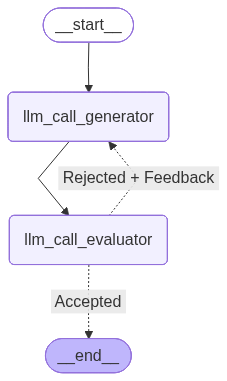

Why did the cat sit on the computer?

To keep an eye on the mouse!


In [ ]:
## Evaluator-optimizer
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [ ]:
## tools
from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

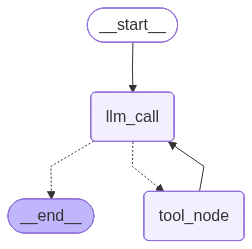

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (d4635402-3690-483f-b1a9-7c4ae7d96acd)
 Call ID: d4635402-3690-483f-b1a9-7c4ae7d96acd
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()